In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
!pip install emcee
import emcee
!pip install corner
import corner
from astropy.cosmology import FlatLambdaCDM
from astropy.cosmology import WMAP9 as cosmo
from astropy.io import fits as pyfits

     |████████████████████████████████| 51kB 2.9MB/s 



Dos parámetros son importantes para determinar la variabilidad restante de la homogeneidad de clases entre las supernovas. La dilatación temporal de la luz $X_{1}$ y el color de la supernova $C$.
El estimador utilizado en este caso es lineal y es el que está a continuación:

$\mu = m_{B}^{\star} - (M_{B} - \alpha \times X_{1} + \beta \times C)$

donde $m_{B}^{*}$ es el pico de la magnitud de la banda $B$, $M_{B}$, $\alpha$ y $\beta$ son parámetros de ajuste a determinarse para que el modelo lineal concuerde con $\mu = 5 log_{10}(d_{L}/10 pc)$, con $d_{L}$ como la distancia luminosa.

In [2]:
import os
print(os.listdir("."))

['.config', 'sample_data']


In [3]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 144865 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.23-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.23-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.23-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope

In [4]:
!mkdir -p drive
!google-drive-ocamlfuse drive -o nonempty

In [5]:
os.chdir("drive/Colab/")

In [6]:
data = np.loadtxt('data/jla_lcparams.txt', usecols = (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19))

In [8]:
N = 740
Z = np.zeros(N)
M_b = np.zeros(N)
e_M_b = np.zeros(N)
X_1 = np.zeros(N)
e_X_1 = np.zeros(N)
C = np.zeros(N)
e_C = np.zeros(N)

masa_estelar = np.zeros(N)
set_ = np.zeros(N)


for i in range(N):
    Z[i] = data[i][0]
    M_b[i] = data[i][3]
    e_M_b[i] = data[i][4]
    X_1[i] = data[i][5]
    e_X_1[i] = data[i][6]
    C[i] = data[i][7]
    e_C[i] = data[i][8]

    masa_estelar[i] = data[i][9]
    set_[i] = data[i][16]

Obtener distancias:

In [9]:
e_tot = np.zeros(N)
par_masa = np.zeros(N)

a = np.zeros((N, N*3))
n = np.zeros ((N*3, 1))
kronecker = np.zeros((N, N*3, 3))


masa_aux = np.ones(N)
D1 = np.zeros((N, N))
D2 = D1
D3 = D1


for i in range(N):
    e_aux = e_M_b[i]**2 + e_X_1[i]**2 + e_C[i]**2
    e_tot[i] = e_aux

    if masa_estelar[i] >= 10:
        par_masa[i] = 1
    else:
        par_masa[i] = 0

    n[3*i] = M_b[i]
    n[3*i + 1] = X_1[i]
    n[3*i + 2] = C[i]

    for j in range(N*3):
        for k in range(3):
            if 3*i == j + k:
                kronecker[i][j][k] = 1
            else:
                kronecker[i][j][k] = 0

    for j in range(740):
        if i == j:
          
            D1[i][j] = ((0.0025)/(Z[i]*math.log(10)))**2
            D2[i][j] = (0.055*Z[i])**2
            
            if set_[i] == 3:
                D3[i][j] = (0.12)**2
            elif set_[i] == 1:
                D3[i][j] = (0.11)**2
            elif set_[i] == 2:
                D3[i][j] = (0.08)**2
            else:
                D3[i][j] = (0.11)**2

In [10]:
c_n = pyfits.open('covmat/C_stat.fits')['PRIMARY'].data + pyfits.open('covmat/C_cal.fits')['PRIMARY'].data + pyfits.open('covmat/C_model.fits')['PRIMARY'].data + pyfits.open('covmat/C_bias.fits')['PRIMARY'].data + pyfits.open('covmat/C_host.fits')['PRIMARY'].data + pyfits.open('covmat/C_dust.fits')['PRIMARY'].data + pyfits.open('covmat/C_pecvel.fits')['PRIMARY'].data + pyfits.open('covmat/C_nonia.fits')['PRIMARY'].data

In [11]:
def Log_prob_mod(Theta, m_b, par_masa, X_1, C, z, err_total):
    lp = Log_prior(Theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + Log_LH_mod(Theta, m_b, par_masa, X_1, C, z, err_total)

def Log_LH_mod(Theta, m_b, par_masa, X_1, C, z, err_total):
    Om, A, B, masa, delta = Theta
    model = m_b - (masa + delta*par_masa - A*X_1 + B*C)
    Om = abs(Om)
    d_l = FlatLambdaCDM(H0 = 70, Om0 = Om, Tcmb0 = 2.725).luminosity_distance(z)
    mu_stand = np.zeros(740)
    for i in range(740):
        mu_stand[i] = 5*math.log10(d_l[i].value/10e-6)
    return -0.5 * np.sum((mu_stand - model) ** 2 / err_total + np.log(err_total))

In [14]:
def Log_LH(Theta):
    Om, A, B, masa, delta = Theta

    for i in range(740):
        for j in range(2220):
            a[i][j] = kronecker[i][j][0] + A*kronecker[i][j][1] + B*kronecker[i][j][2]  
    a_trans = np.transpose(a)    


    Om = abs(Om)
    d_l = FlatLambdaCDM(H0 = 70, Om0 = Om, Tcmb0 = 2.725).luminosity_distance(Z)
    model = np.matmul(a, n) - (masa*masa_aux).reshape(740, 1) + (delta*par_masa).reshape(740, 1)

    mu_stand = np.zeros(740)
    for i in range(740):

        mu_stand[i] = 5*math.log10(d_l[i].value/10e-6)


    LH_aux = model - mu_stand.reshape(740, 1)  
    LH_aux_trans = np.transpose(LH_aux)

    c_cov = np.matmul(np.matmul(a, c_n), a_trans) + D1 + D2 + D3
    c_cov_inv = np.linalg.inv(c_cov)


    return np.matmul(np.matmul(LH_aux_trans, c_cov_inv), LH_aux)

def Log_prior(Theta):
    Om, A, B, masa, delta = Theta
    if 0.0 < Om < 1.0 and 0.0 < A < 1.0 and 3 < B < 4 and -20 < masa < -19 and -1.0 < delta < 0.0:
        prior = 0
    else:
        prior = -np.inf
    return prior

def Log_probability(Theta):
    log_p = Log_prior(Theta)
    if not np.isfinite(log_p):
        return -np.inf
    return log_p + Log_LH(Theta)

In [ ]:
pos = [0.3, 0.15, 3.0, -19.0, -0.0070] + 1e-4 * np.random.randn(10, 5)
nwalkers, ndim = pos.shape

sampler_model = emcee.EnsembleSampler(nwalkers, ndim, Log_prob_mod, args=(M_b, par_masa, X_1, C, Z, e_tot))
sampler_model.run_mcmc(pos, 10000, progress=True);

  0%|          | 0/10000 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 10000/10000 [18:59<00:00,  8.78it/s]


In [ ]:
flat_samples = sampler_model.get_chain(discard=100, thin=15, flat=True)    #flat=True
print(flat_samples.shape)

(6600, 5)


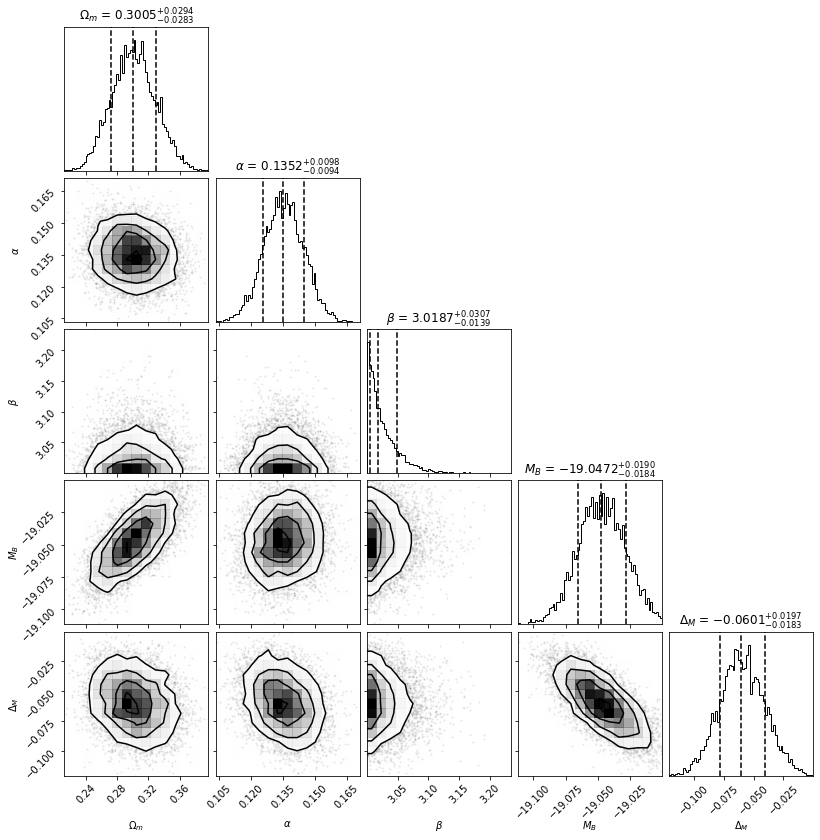

In [ ]:
fig = corner.corner(
    flat_samples,
    bins = 15,
    hist_bin_factor = 5,
    labels=[r"$\Omega_m$", r"$\alpha$", r"$\beta$", r"$M_{B}$", r"$\Delta_M$"],
    quantiles = [0.16, 0.5, 0.84],
    title_fmt = '.4f',
    show_titles = True, title_kwargs={"fontsize": 12}
);

In [ ]:
from IPython.display import display, Math
labels = [r"\Omega_m", r"\alpha",r"\beta",r"M_{B}",r"\Delta_M"]
R = np.zeros(ndim)
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    R[i] = mcmc[1]
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

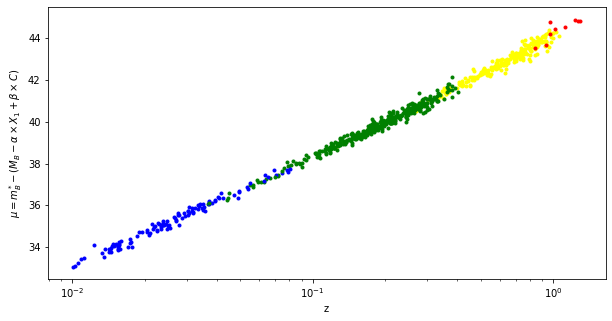

In [ ]:
plt.figure(figsize=(10,5))
for i in range(740):
    if set_[i] == 3:
        plt.plot(z[i], M_b[i] - (R[3] + R[4]*par_masa[i] - R[1]*X_1[i] + R[2]*C[i]), '.', color = 'b')
    elif set_[i] == 1:
        plt.plot(z[i], M_b[i] - (R[3] + R[4]*par_masa[i] - R[1]*X_1[i] + R[2]*C[i]), '.', color = 'yellow')
    elif set_[i] == 2:
        plt.plot(z[i], M_b[i] - (R[3] + R[4]*par_masa[i] - R[1]*X_1[i] + R[2]*C[i]), '.', color = 'green')
    else:
        plt.plot(z[i], M_b[i] - (R[3] + R[4]*par_masa[i] - R[1]*X_1[i] + R[2]*C[i]), '.', color = 'r')

plt.xscale('log')
plt.xlabel('z')
plt.ylabel(r'$\mu = m_{B}^{*} - (M_{B} - \alpha \times X_{1} + \beta \times C)$');

Para hacer inferencia de parámetros necesitamos definir unas nuevas matrices que ayudaran al cálculo del likelihood (función en una celda de arriba)

In [12]:
e_tot = np.zeros(N)
par_masa = np.zeros(N)

a = np.zeros((N, N*3))
n = np.zeros ((N*3, 1))
kronecker = np.zeros((N, N*3, 3))


masa_aux = np.ones(N)
D1 = np.zeros((N, N))
D2 = D1
D3 = D1


for i in range(N):
    e_aux = e_M_b[i]**2 + e_X_1[i]**2 + e_C[i]**2
    e_tot[i] = e_aux

    if masa_estelar[i] >= 10:
        par_masa[i] = 1
    else:
        par_masa[i] = 0

    n[3*i] = M_b[i]
    n[3*i + 1] = X_1[i]
    n[3*i + 2] = C[i]

    for j in range(N*3):
        for k in range(3):
            if 3*i == j + k:
                kronecker[i][j][k] = 1
            else:
                kronecker[i][j][k] = 0

    for j in range(740):
        if i == j:
          
            D1[i][j] = ((0.0025)/(Z[i]*math.log(10)))**2
            D2[i][j] = (0.055*Z[i])**2
            

            if set_[i] == 1:
                D3[i][j] = (0.11)**2
            elif set_[i] == 2:
                D3[i][j] = (0.08)**2
            elif set_[i] == 3:
                D3[i][j] = (0.12)**2
            else:
                D3[i][j] = (0.11)**2

In [ ]:
pos_i = [0.3, 0.2, 3.2, -19.5, -0.1] + 0.001*np.random.randn(10, 5)
nwalkers, ndim = pos_i.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, Log_probability)
sampler.run_mcmc(pos_i, 1000, progress=True);

100%|██████████| 1000/1000 [10:53:08<00:00, 39.19s/it]


In [ ]:
flat_samples = sampler.get_chain(discard=15, thin=15, flat=True)    #flat=True
print(flat_samples.shape)

(650, 5)


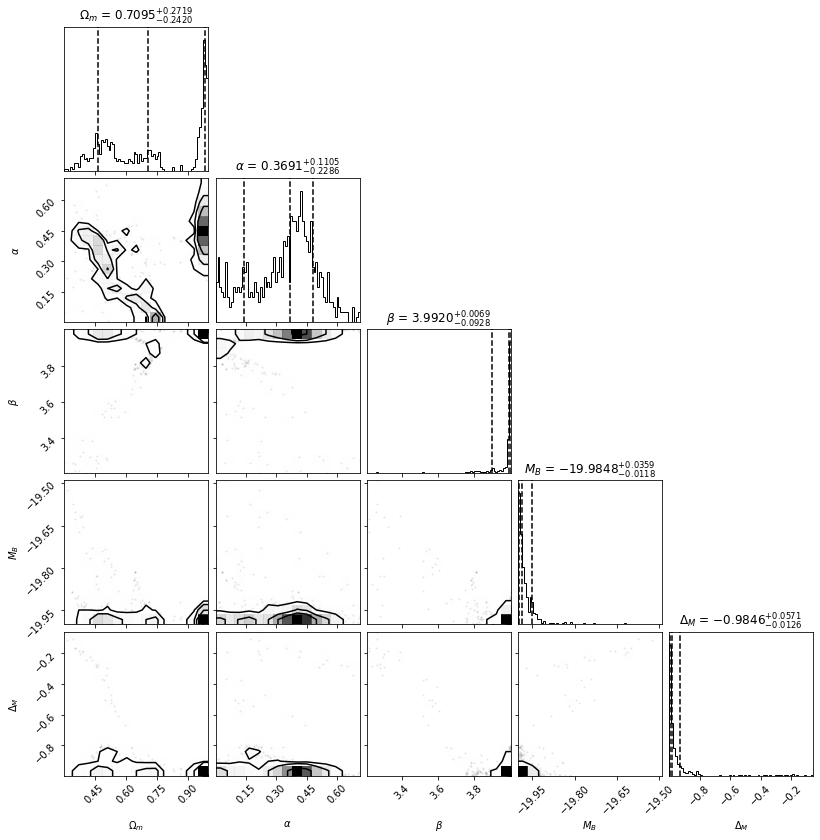

In [ ]:
fig = corner.corner(
    flat_samples,
    bins = 15,
    hist_bin_factor = 5,
    labels=[r"$\Omega_m$", r"$\alpha$", r"$\beta$", r"$M_{B}$", r"$\Delta_M$"],
    quantiles = [0.16, 0.5, 0.84],
    title_fmt = '.4f',
    show_titles = True, title_kwargs={"fontsize": 12}
    

);

In [ ]:
from IPython.display import display, Math
labels = [r"\Omega_m", r"\alpha",r"\beta",r"M_{B}",r"\Delta_M"]
res = np.zeros(ndim)
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    res[i] = mcmc[1]
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Text(0, 0.5, '$\\mu = m_{B}^{*} - (M_{B} - \\alpha \\times X_{1} + \\beta \\times C)$')

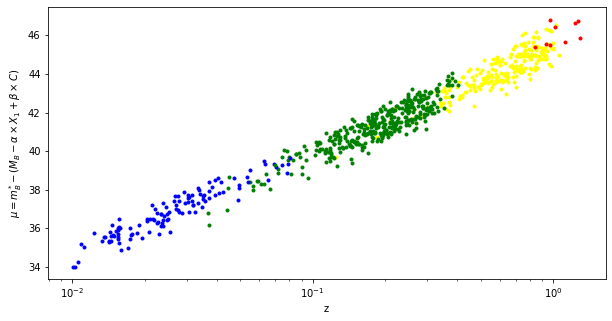

In [ ]:
plt.figure(figsize=(10,5))
for i in range(N):
    if set_[i] == 3:
        plt.plot(Z[i], M_b[i] - (res[3] + res[4]*par_masa[i] - res[1]*X_1[i] + res[2]*C[i]), '.', color = 'blue')
    elif set_[i] == 1:
        plt.plot(Z[i], M_b[i] - (res[3] + res[4]*par_masa[i] - res[1]*X_1[i] + res[2]*C[i]), '.', color = 'yellow')
    elif set_[i] == 2:
        plt.plot(Z[i], M_b[i] - (res[3] + res[4]*par_masa[i] - res[1]*X_1[i] + res[2]*C[i]), '.', color = 'green')
    else:
        plt.plot(Z[i], M_b[i] - (res[3] + res[4]*par_masa[i] - res[1]*X_1[i] + res[2]*C[i]), '.', color = 'red')

plt.xscale('log')
plt.xlabel('z')
plt.ylabel(r'$\mu = m_{B}^{*} - (M_{B} - \alpha \times X_{1} + \beta \times C)$')

lowz + SNLS (incompleto):

In [ ]:
counter = 0
for i in range(740):
  if data[i,16]==3.:
    counter = 1 + counter
  elif data[i,16]==1.:
    counter = 1 + counter

LOWZySNLS = np.zeros([counter,19]) 
reps = 0 
for i in range(counter):

  if data[i,16]==3 or data[i,16] == 1:
    LOWZySNLS[reps,0:] = data[i,0:]
    reps = reps+1 

In [ ]:
Z = np.zeros(reps)
M_b = np.zeros(reps)
e_M_b = np.zeros(reps)
X_1 = np.zeros(reps)
e_X_1 = np.zeros(reps)
C = np.zeros(reps)
e_C = np.zeros(reps)
masa_estelar = np.zeros(reps)
conjunto = np.zeros(reps)

for i in range(reps):

  Z[i] = LOWZySNLS[i][0]
  M_b[i] = LOWZySNLS[i][3]
  e_M_b[i] = LOWZySNLS[i][4]
  X_1[i] = LOWZySNLS[i][5]
  e_X_1[i] = LOWZySNLS[i][6]
  C[i] = LOWZySNLS[i][7]
  e_C[i] = LOWZySNLS[i][8]

  masa_estelar[i] = LOWZySNLS[i][9]
set_[i] = LOWZySNLS[i][16]

In [ ]:
for i in range(reps):
    err_total[i] =  e_M_b[i]**2 + e_X_1[i]**2 + e_C[i]**2

    if masa_estelar[i] >= 10:
        par_masa[i] = 1
    else:
        par_masa[i] = 0

    

intento hacerlo para más valores

In [ ]:
n[3*i] = M_b[i]
n[3*i + 1] = X_1[i]
n[3*i + 2] = C[i]


D1 = np.zeros((N, N))
D2 = D1
D3 = D1
    
    
for j in range(N*3):
    for k in range(3):
        if 3*i == j + k:
            kronecker[i][j][k] = 1
        else:
            kronecker[i][j][k] = 0

for j in range(N):
    if i == j:
          
        D1[i][j] = ((0.0025)/(Z[i]*math.log(10)))**2
        D2[i][j] = (0.055*Z[i])**2
            
        if set_[i] == 3:
            D3[i][j] = (0.12)**2
        elif set_[i] == 1:
             D3[i][j] = (0.11)**2
        elif set_[i] == 2:
             D3[i][j] = (0.08)**2
        else:
             D3[i][j] = (0.11)**2

In [15]:
pos_i = [0.3, 0.2, 3.2, -19.5, -0.1] + 0.001*np.random.randn(10, 5)
nwalkers, ndim = pos_i.shape

sampler4 = emcee.EnsembleSampler(nwalkers, ndim, Log_probability)
sampler4.run_mcmc(pos_i, 1300, progress=True);

100%|██████████| 1300/1300 [11:14:10<00:00, 31.12s/it]


In [16]:
flat_samples = sampler4.get_chain(discard=15, thin=15, flat=True)  

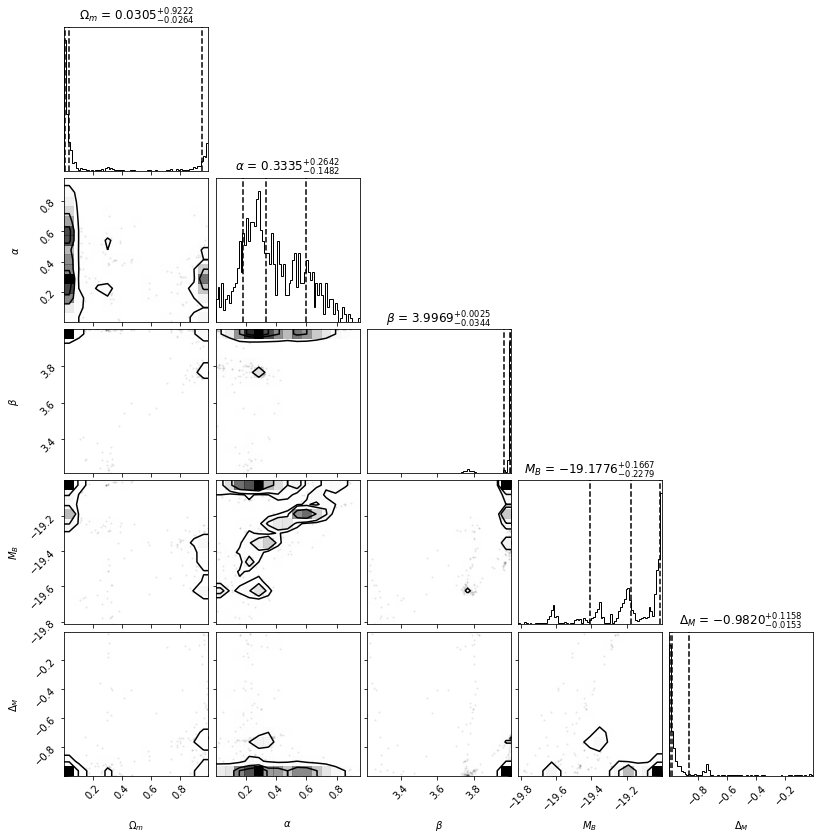

In [17]:
fig = corner.corner(
    flat_samples,
    bins = 15,
    hist_bin_factor = 5,
    labels=[r"$\Omega_m$", r"$\alpha$", r"$\beta$", r"$M_{B}$", r"$\Delta_M$"],
    quantiles = [0.16, 0.5, 0.84],
    title_fmt = '.4f',
    show_titles = True, title_kwargs={"fontsize": 12}
    

);

In [18]:
from IPython.display import display, Math
labels = [r"\Omega_m", r"\alpha",r"\beta",r"M_{B}",r"\Delta_M"]
res = np.zeros(ndim)
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    res[i] = mcmc[1]
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Text(0, 0.5, '$\\mu = m_{B}^{*} - (M_{B} - \\alpha \\times X_{1} + \\beta \\times C)$')

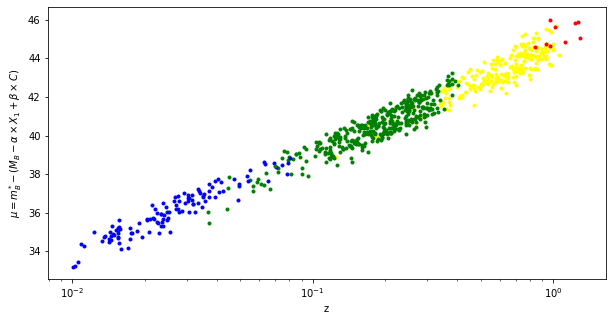

In [20]:
plt.figure(figsize=(10,5))
for i in range(N):
    if set_[i] == 3:
        plt.plot(Z[i], M_b[i] - (res[3] + res[4]*par_masa[i] - res[1]*X_1[i] + res[2]*C[i]), '.', color = 'blue')
    elif set_[i] == 1:
        plt.plot(Z[i], M_b[i] - (res[3] + res[4]*par_masa[i] - res[1]*X_1[i] + res[2]*C[i]), '.', color = 'yellow')
    elif set_[i] == 2:
        plt.plot(Z[i], M_b[i] - (res[3] + res[4]*par_masa[i] - res[1]*X_1[i] + res[2]*C[i]), '.', color = 'green')
    else:
        plt.plot(Z[i], M_b[i] - (res[3] + res[4]*par_masa[i] - res[1]*X_1[i] + res[2]*C[i]), '.', color = 'red')

plt.xscale('log')
plt.xlabel('z')
plt.ylabel(r'$\mu = m_{B}^{*} - (M_{B} - \alpha \times X_{1} + \beta \times C)$')